<h1><center> Individual Data Noise Creation <br><br> 
<center> Scikit Mobility and DB Noise<br><br> 
Wendy Shi</center></center>

# TOC


# Preparation

In [2]:
#Preparation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics

# County Level FIP Code

In [4]:
column_names = ['S', 'E', 'I', 'R']
Seeding = pd.read_csv("../../Data/seed_1503_seed_corrected_undereporting_CDC_corrected_v3.txt",
                     delimiter=' ',
                      names=column_names)
print(Seeding.shape)
Seeding.tail(3)

(2327, 4)


,S,E,I,R
2324,42158,0,0,0
2325,23347,0,0,0
2326,20441,0,0,0


In [5]:
node_dict = pd.read_csv("../../Data/nodes_considered.csv")
node_dict = node_dict.drop(columns = ['index'])
print(node_dict.shape)
node_dict.tail(3)

(2327, 1)


,GEO_ID
2324,56037
2325,56039
2326,56041


In [6]:
node_dict['Population'] = Seeding['S']
node_dict.tail(5)

,GEO_ID,Population
2322,56029,29656
2323,56033,30996
2324,56037,42158
2325,56039,23347
2326,56041,20441


In [7]:
#Check if node dictionary size equals to size of E, and see if they all have population larger than 11,000
desired = node_dict[node_dict['Population'] > 11000]
print(desired.shape)

node_dict["GEO_ID"] = node_dict["GEO_ID"].apply(lambda x: f"{int(x):05d}")

#rename column
rename = {'GEO_ID' : 'GEOID'}
node_dict = node_dict.rename(columns = rename)
node_dict.head(3)

(2327, 2)


,GEOID,Population
0,01001,58877
1,01003,233140
2,01005,25180


In [8]:
node_dict['state'] = node_dict['GEOID'].str[:2]
node_dict['index'] = range(len(node_dict))
node_dict.head(3)

,GEOID,Population,state,index
0,01001,58877,01,0
1,01003,233140,01,1
2,01005,25180,01,2


In [9]:
california = node_dict[node_dict['state'] == '06']

#Index list--------------This is the one that check if weight matrix is in the same order as SEIR initial condition
E_ca_index = california['GEOID'].to_list()

#Population list
pop_list = california['Population'].tolist()

#Print the dataset
print(california.shape)
california.head(3)

(55, 4)


,GEOID,Population,state,index
133,06001,1679809,06,133
134,06005,40541,06,134
135,06007,210083,06,135


In [10]:
index = california['index'].tolist()
print(index)

[133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187]


In [11]:
ca_geoid = california['GEOID'].tolist()
len(ca_geoid)

55

# Safegraph Data

In [12]:
#Open the 12 weight matrix
column_names = ['origin', 'destination', 'count', 'weight']
for i in range(12):
    n = i +1
    
    df = pd.read_csv(f"../../Data/monthly_matrix_sd_county_month{n}_county.txt", 
                     delimiter=' ', names=column_names)
    
    #Making sure all origin and destination are states in New York
    df = df[(df['origin'].isin(index)) & (df['destination'].isin(index))]
    
    # Store the modified DataFrame
    globals()[f'wt_mt{n}'] = df

In [13]:
wt_mt12.head(3)

,origin,destination,count,weight
666785,133,160,12,0.001625
666786,134,160,12,0.000762
666787,135,160,12,0.001418


In [14]:
#Turn each data into a matrix
#Transform the dataframe to a matrix with pivot table
for i in range(12):
    n = i+1
    matrix = globals()[f'wt_mt{n}'].pivot_table(index='origin', 
                                                columns='destination', 
                                                values= 'weight', fill_value=0)
    matrix = matrix.reset_index()
    matrix = matrix.drop(columns = ["origin"]) #drop the origin column
    globals()[f'matrix{n}'] = matrix

In [15]:
for i in range(12):
    n = i +1
    count_df = globals()[f'matrix{n}'].multiply(pop_list, axis=0)
    globals()[f'count_df{n}'] = count_df

In [16]:
average_count_df = sum(globals()[f'count_df{i}'] for i in range(1, 13)) / 12
print(average_count_df.shape)
average_count_df.head(3)

(55, 55)


destination,133,134,135,136,137,138,139,140,141,142,...,178,179,180,181,182,183,184,185,186,187
0,1.385115e+06,384.851020,632.076178,997.738719,117.342903,49934.887892,67.485674,2388.800785,1785.911501,114.582670,...,3111.343937,4065.864401,162.995987,212.304175,55.338508,462.234899,953.562215,464.473766,1405.799067,221.531588
1,1.824813e+02,27697.231839,55.780957,768.669779,25.110230,183.553679,17.647097,826.905638,51.336604,17.786663,...,55.957240,147.349261,22.984144,28.494406,7.117470,26.569048,90.593715,19.856297,175.216459,27.609414
2,5.015091e+02,44.175430,175039.933418,61.218832,357.018136,517.530012,82.227387,343.799628,267.389507,1452.730627,...,302.252421,231.145286,2711.072897,1491.104069,63.782303,105.506045,54.044253,108.106379,370.158029,1472.597195


In [17]:
#Turn count to weight
divisor = [average_count_df.iloc[i].sum() for i in range(55)]
average_wt_mt = average_count_df.div(divisor, axis=0)
average_wt_mt.head(3)

destination,133,134,135,136,137,138,139,140,141,142,...,178,179,180,181,182,183,184,185,186,187
0,0.851945,0.000237,0.000389,0.000614,0.000072,0.030714,0.000042,0.001469,0.001098,0.000070,...,0.001914,0.002501,0.000100,0.000131,0.000034,0.000284,0.000587,0.000286,0.000865,0.000136
1,0.005070,0.769577,0.001550,0.021358,0.000698,0.005100,0.000490,0.022976,0.001426,0.000494,...,0.001555,0.004094,0.000639,0.000792,0.000198,0.000738,0.002517,0.000552,0.004868,0.000767
2,0.002539,0.000224,0.886122,0.000310,0.001807,0.002620,0.000416,0.001740,0.001354,0.007354,...,0.001530,0.001170,0.013725,0.007549,0.000323,0.000534,0.000274,0.000547,0.001874,0.007455


In [18]:
average_wt_mt_np = average_wt_mt.to_numpy()

In [19]:
average_wt_mt_np[0][0]

0.8519449854950997

In [20]:
Pii_ori = [average_wt_mt_np[i][i] for i in range(55)]

In [21]:
data = Pii_ori 
mean_value = sum(data) / len(data)  # Mean
median_value = statistics.median(data)  # Median
min_value = min(data)  # Min
max_value = max(data)  # Max

# Output
print(f"Mean: {mean_value}")
print(f"Median: {median_value}")
print(f"Min: {min_value}")
print(f"Max: {max_value}")
print(f"Length of the list: {len(Pii_ori)}")

Mean: 0.8306907366531073
Median: 0.8450679400638644
Min: 0.64390644460179
Max: 0.9566359515435788
Length of the list: 55


In [22]:
print(len(Pii_ori))

55


# Cuebiq Data

In [23]:
cuebiq = pd.read_csv("county_trajectories.csv")
cuebiq.head(3)

,HOME_COUNTY_FIPS,STOP_DATE,STOP_COUNTY_FIPS,VISIT_CT,visit_ct_P8,visit_ct_P5,visit_ct_P3,visit_ct_P1,visit_ct_P05,visit_ct_P01,visit_ct_P005
0,6001,2019-03-01 00:00:00.000,4013,3,5,3,2,9,15,74,149
1,6001,2019-03-01 00:00:00.000,6001,561,664,803,974,1778,4327,19650,47811
2,6001,2019-03-01 00:00:00.000,6005,1,2,1,1,6,75,0,76


In [24]:
cuebiq.columns

Index(['HOME_COUNTY_FIPS', 'STOP_DATE', 'STOP_COUNTY_FIPS', 'VISIT_CT',
       'visit_ct_P8', 'visit_ct_P5', 'visit_ct_P3', 'visit_ct_P1',
       'visit_ct_P05', 'visit_ct_P01', 'visit_ct_P005'],
      dtype='object')

In [25]:
cuebiq["HOME_COUNTY_FIPS"] = cuebiq["HOME_COUNTY_FIPS"].apply(lambda x: f"{int(x):05d}")
cuebiq["STOP_COUNTY_FIPS"] = cuebiq["STOP_COUNTY_FIPS"].apply(lambda x: f"{int(x):05d}")
cuebiq.head(3)

,HOME_COUNTY_FIPS,STOP_DATE,STOP_COUNTY_FIPS,VISIT_CT,visit_ct_P8,visit_ct_P5,visit_ct_P3,visit_ct_P1,visit_ct_P05,visit_ct_P01,visit_ct_P005
0,06001,2019-03-01 00:00:00.000,04013,3,5,3,2,9,15,74,149
1,06001,2019-03-01 00:00:00.000,06001,561,664,803,974,1778,4327,19650,47811
2,06001,2019-03-01 00:00:00.000,06005,1,2,1,1,6,75,0,76


In [26]:
ca_sub = cuebiq[(cuebiq["HOME_COUNTY_FIPS"].isin(ca_geoid))&(cuebiq["STOP_COUNTY_FIPS"].isin(ca_geoid))].copy()
ca_sub['STOP_DATE'] = pd.to_datetime(ca_sub['STOP_DATE'])
ca_sub.insert(2, "day", ca_sub['STOP_DATE'].dt.day)
ca_sub.head(3)

,HOME_COUNTY_FIPS,STOP_DATE,day,STOP_COUNTY_FIPS,VISIT_CT,visit_ct_P8,visit_ct_P5,visit_ct_P3,visit_ct_P1,visit_ct_P05,visit_ct_P01,visit_ct_P005
1,06001,2019-03-01,1,06001,561,664,803,974,1778,4327,19650,47811
2,06001,2019-03-01,1,06005,1,2,1,1,6,75,0,76
3,06001,2019-03-01,1,06013,22,23,42,46,62,144,351,879


In [27]:
ca_sub['day'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
      dtype=int32)

## Function1: Set of daily matrix

In [29]:
def avg_mt_epsilon(ori_des_df, Count, all_fips): #Asked Chat GTP to help me edit my functions
    """
    Calculates a dictionary of daily mobility matrices with fixed row and column labels.

    Parameters:
    - ori_des_df: DataFrame containing 'HOME_COUNTY_FIPS', 'STOP_COUNTY_FIPS', 'day', and the count column
    - Count: str, name of the count column (e.g., 'VISIT_CT')
    - all_fips: list of all FIPS codes to enforce as row and column labels

    Returns:
    - Matrix_dict: dict mapping day (1–30) to a square DataFrame with rows/columns = all_fips
    """
    Matrix_dict = {}

    for n in sorted(ori_des_df['day'].unique()):
        df = ori_des_df[ori_des_df['day'] == n]
        county_group = df.groupby(['HOME_COUNTY_FIPS', 'STOP_COUNTY_FIPS'])[Count].sum().reset_index()

        # Create pivot table
        count_Matrix = county_group.pivot_table(index='HOME_COUNTY_FIPS',
                                                columns='STOP_COUNTY_FIPS',
                                                values=Count,
                                                fill_value=0)

        # Enforce consistent index and columns
        count_Matrix = count_Matrix.reindex(index=all_fips, columns=all_fips, fill_value=0)

        # Drop index name for consistency
        count_Matrix.index.name = None
        count_Matrix.columns.name = None

        # Save matrix to dictionary
        Matrix_dict[n] = count_Matrix.reset_index(drop=True)

    return Matrix_dict

## Function 2: Monthly averaged matrix

In [30]:
def daily_avg_wtmt(Matrix_dict):
    
    '''
    This function compute the daily average mobility matrix
    '''
    total_visit = Matrix_dict[1].copy()
    
    for i in range(1, 31):
        n = i + 1 #n therefore starts from 2
        #print(n)
        
        if n % 10 == 0:
            print(n)
            
        total_visit += Matrix_dict[n]
        
    daily_avg_visit = total_visit/30
    
    divisor = [daily_avg_visit.iloc[i].sum() for i in range(55)]
    average_wt_mt = daily_avg_visit.div(divisor, axis=0)
    
    return average_wt_mt

## Applying matrix

## First Function

In [31]:
ca_sub.head(5)

,HOME_COUNTY_FIPS,STOP_DATE,day,STOP_COUNTY_FIPS,VISIT_CT,visit_ct_P8,visit_ct_P5,visit_ct_P3,visit_ct_P1,visit_ct_P05,visit_ct_P01,visit_ct_P005
1,06001,2019-03-01,1,06001,561,664,803,974,1778,4327,19650,47811
2,06001,2019-03-01,1,06005,1,2,1,1,6,75,0,76
3,06001,2019-03-01,1,06013,22,23,42,46,62,144,351,879
4,06001,2019-03-01,1,06029,1,0,4,0,2,32,0,0
5,06001,2019-03-01,1,06037,1,0,0,0,0,1,68,7


In [33]:
#order from the SEIR model
#E_ca_index

In [48]:
# VISIT_CT, visit_ct_P8
CA_set = avg_mt_epsilon(ca_sub, 'visit_ct_P8', E_ca_index)
CA_set[31].head(3)

,06001,06005,06007,06009,06011,06013,06015,06017,06019,06021,...,06097,06099,06101,06103,06105,06107,06109,06111,06113,06115
0,431,4,7,0,0,30,0,13,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,3,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,65,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0


## Second Function

In [165]:
daily_avg = daily_avg_wtmt(CA_set)
daily_avg.head(3)

10
20
30


,06001,06005,06007,06009,06011,06013,06015,06017,06019,06021,...,06097,06099,06101,06103,06105,06107,06109,06111,06113,06115
0,0.727168,0.000337,0.000866,0.000674,0.000000,0.035367,0.0,0.002310,0.001444,0.000096,...,0.001203,0.001588,0.000000,0.000000,0.0,0.0,0.000096,0.001203,0.002839,0.000048
1,0.002801,0.518207,0.000000,0.005602,0.000000,0.008403,0.0,0.036415,0.000000,0.000000,...,0.000000,0.005602,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2,0.004463,0.000000,0.846350,0.000000,0.015939,0.004463,0.0,0.002869,0.001275,0.002869,...,0.005100,0.001275,0.018489,0.001275,0.0,0.0,0.000000,0.000000,0.012432,0.004782


In [162]:
daily_avg.to_csv("cb_ori_indi.csv")

In [167]:
# Calculations
import statistics

average_wt_mt_np = daily_avg.to_numpy()
Pii_skmob = [average_wt_mt_np[i][i] for i in range(55)]


data = Pii_skmob 
mean_value = sum(data) / len(data)  # Mean
median_value = statistics.median(data)  # Median
min_value = min(data)  # Min
max_value = max(data)  # Max

# Output
print(f"Mean: {mean_value}")
print(f"Median: {median_value}")
print(f"Min: {min_value}")
print(f"Max: {max_value}")

Mean: 0.7115247206810282
Median: 0.7271677413145992
Min: 0.20588235294117643
Max: 0.9883449883449884


# Visualization

In [156]:
#Pii_cb

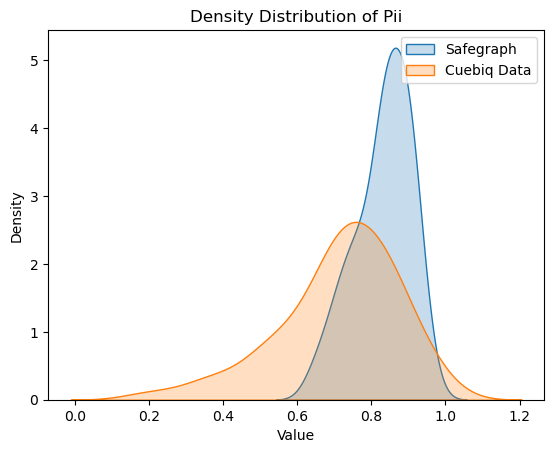

In [157]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Create KDE plot
sns.kdeplot(Pii_ori, label="Safegraph", fill=True)
sns.kdeplot(Pii_cb, label="Cuebiq Data", fill=True)

# Labels and legend
plt.xlabel("Value")
plt.ylabel("Density")
plt.title("Density Distribution of Pii")
plt.legend()

#Lables and legend
#plt.savefig("Pii_Comparison.png", dpi=300, bbox_inches='tight')

# Show plot
plt.show()


# Check Why

In [106]:
pop_visit = california.copy()

In [108]:
pop_visit = california.copy() #Create a new dataframe that contains
pop_visit['total_vt'] = divisor
pop_visit.head()

,GEOID,Population,state,index,total_vt
133,06001,1679809,06,133,734.088613
134,06005,40541,06,134,20.883708
135,06007,210083,06,135,152.124661
136,06009,45327,06,136,17.360623
137,06011,21853,06,137,9.500000
